# Importing libraries

In [2]:
import matplotlib.pyplot as plt

from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import cv2
import pickle
import sparse
import numpy as np

In [ ]:
def load_sparce_npz(path:str):
    '''
    Loads npy array as sparce pickled scipy matrix.
    '''
    with open(path,'rb') as file:
        s = pickle.load(file)
    
    # convert to numpy array
    s = s.todense()
    if len(s.shape) == 2:
      return s
    return np.transpose(s,[1,2,0])

# Loading test mask

In [ ]:
mask = load_sparce_npz(r"path to mask file")

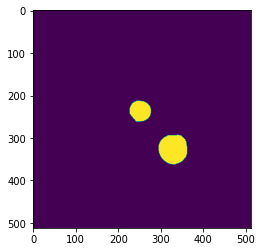

In [ ]:
plt.imshow(mask)

# My method

In [20]:
def get_ellipse_stats(mask,draw_picture=False):
    edges = canny(mask, sigma=2.0,
              low_threshold=0.55, high_threshold=0.8)
    result = hough_ellipse(edges,accuracy=15,min_size=8)
    result.sort(order='accumulator')
    best = list(result[-1])
    yc, xc, a, b = [x for x in best[1:5]]
    
    if draw_picture:
        orientation = best[5]
        # Draw the ellipse on the original image
        cy, cx = ellipse_perimeter(int(yc), int(xc), int(a), int(b), orientation)
        # Draw the edge (white) and the resulting ellipse (red)
        edges = color.gray2rgb(img_as_ubyte(edges))
        edges = draw_ellipse_axis(edges,yc,xc,a,b,orientation)
        edges[cy, cx] = (250, 0, 0)
        plt.figure(figsize=(7,7))
        plt.imshow(edges)
        plt.axis('off')
        plt.show()
    return (a*2,b*2)

def get_line_stats(yc,xc,half_length,orientation):
    x1 = xc - np.cos(orientation) * half_length
    x2 = xc + np.cos(orientation) * half_length
    
    y1 = yc - np.sin(orientation) * half_length
    y2 = yc + np.sin(orientation) * half_length
    
    return ((int(x1),int(y1)),(int(x2),int(y2)))

def draw_ellipse_axis(image,yc, xc, a, b,orientation,text=None):
    
    bigger_color = (0, 255, 0)
    smaller_color = (0, 120, 255)
    # getting axis start-end
    if a>b:
        a_color = bigger_color
        b_color = smaller_color
    else:
        b_color = bigger_color
        a_color = smaller_color
        
    xy1,xy2 = get_line_stats(yc,xc,a,orientation + 3.14/2)
    # line
    image = cv2.line(image, xy1,xy2, a_color, 1)
    
    xy1,xy2 = get_line_stats(yc,xc,b,orientation)
    # line
    image = cv2.line(image, xy1,xy2, b_color, 1)
    # text
    if text:
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image, text, (xc,yc), font, 1, 255, 2)

        # Rotate the image using cv2.warpAffine()
        M = cv2.getRotationMatrix2D(text_location, angle, 1)
        out = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    
    return image
    
def delete_blob(image,coordinates):
    flood_img = np.copy(image)
    #mask = np.zeros((H+2, W+2), np.uint8)
    _ = cv2.floodFill(flood_img,None,coordinates,255)
    return flood_img

def find_aorta_pixel_size(image,draw_ellipse_picture= False):
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 0
    params.maxThreshold = 200

    # Set Area filtering parameters
    params.filterByArea = True
    params.minArea = 10
    #params.maxArea = 1000000

    # Set Circularity filtering parameters
    params.filterByCircularity = False
    params.minCircularity = 0.5

    # Set Convexity filtering parameters
    params.filterByConvexity = False
    params.minConvexity = 0.6

    # Set inertia filtering parameters
    params.filterByInertia = False
    params.minInertiaRatio = 0.01

    # Create a detector with the parameters
    detector = cv2.SimpleBlobDetector_create(params)

    # Detect blobs
    test_image = image.copy().astype('uint8')
    test_image[test_image==1] = 255
    test_image = cv2.bitwise_not(test_image)
    #test_image = cv2.bitwise_not(test_image)
    keypoints = detector.detect(test_image)
    if len(keypoints) > 2:
        print(f'Error: {len(keypoints)} detected')
        raise
    elif len(keypoints) == 2:
        sizes = []
        for k in keypoints:
            coord = [int(p) for p in k.pt]
            clean_img = delete_blob(test_image,coord)
            #plt.imshow(clean_img)
            sizes.append(get_ellipse_stats(clean_img,draw_ellipse_picture))
    else:
        sizes = []
        sizes.append(get_ellipse_stats(test_image,draw_ellipse_picture))
    return sizes

def find_aorta_size(image,pixel_spacing = 0.7808):
    return [pixels * pixel_spacing for pixels in find_aorta_pixel_size(image)]

# Testing method

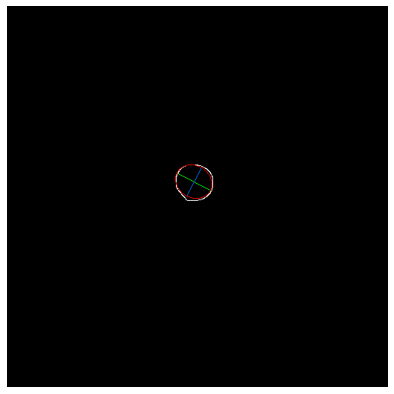

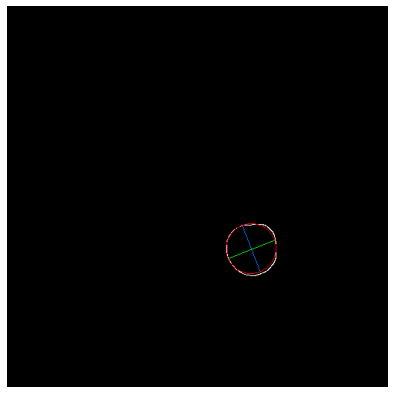

[(51.478150704935004, 42.42640687119285),
 (67.08203932499369, 67.77905281132217)]

In [21]:
find_aorta_pixel_size(mask,True)